# **Market Basket Analysis**

Market Basket Analysis is a technique based on the theory that if you buy a certain group of items, you are more or less likely to buy another group of items. Market basket analysis may provide the companies with insights to understand the purchase behavior of a customer. This information can then be used for purposes of  influencing sales, promotions, loyalty programs, store design, and discount plans, etc.

- Our objective here is to recommend products to the user based on the current item selected by the user. We will be using Association rules to determine which products to recommend to the user. 
- Further on we have used Kmeans clustering to divide the customers into groups or clusters based on their common characteristics (i.e what kind of products they buy) and determine which set of customers prefers buying which set of products.

# **Mounting the Google Drive**

Execute the following cell if you will be running the notebook in Google Colab. - The following code mounts your google drive in the colab notebook for you to access data stored on your drive. 
- If using google colab the dataset needs to be uploaded on your google drive and then the drive needs to be mounted with the following code. 
- When you run the following cell it asks you to go to a URL. Clicking on that it prompts you to chose your google account. 
- Select the account where your data is uploaded.
- Click on "Allow" to give necessary permissions.
- Copy the authentication code and paste in in the box below the URL and hit 'Enter'
- You will get the following message "Mounted at /content/drive" indicating that your drive is no mounted and ready to use 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing necessary Libraries**

In [2]:
import numpy as np
import pandas as pd 
import gc
import os

#Libraries for plotting
import matplotlib
import matplotlib.pyplot as plt  
import seaborn as sns

#Libraries for Apriori Algorithm for association rules mining
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#Libraries for Customer Segmentation using KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# To calculate time elapsed
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Data Folder path**
- If using Google Colab your path should start with "/content/drive/My Drive/" followed by folder path in which the data in uploaded on your drive.
- On local system use the path of folder where your data is located.

In [0]:
data_folder_path = '/content/drive/My Drive/Colab Notebooks/data'

## **Reading Data**

In [0]:
aisles = pd.read_csv(data_folder_path + '/aisles.csv')
departments = pd.read_csv(data_folder_path + '/departments.csv')
order_products_prior = pd.read_csv(data_folder_path + '/order_products__prior.csv')
order_products_train = pd.read_csv(data_folder_path + '/order_products__train.csv')
orders = pd.read_csv(data_folder_path + '/orders.csv')
products = pd.read_csv(data_folder_path + '/products.csv')


# **Association Rule Mining using Apriori Algorithm**

## The following segement is divided into 2 parts
## 1. Calculating frequent itemsets
## 2. Generating Association rules based on them

In [5]:
# Merging the necessary Dataframes to get the required data
order_products = order_products_prior.append(order_products_train)
order_products.shape

(33819106, 4)

In [6]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
# Filtering out duplicate product entries. Keeping only one entry per item
order_products.product_id.nunique()

49685

In [8]:
# Out of 49685 keeping top 100 most frequent products.

product_counts = order_products.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop = True)
product_counts = product_counts.merge(products, on = 'product_id', how = 'left')
product_counts.head(10)

,product_id,frequency,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4
5,47766,184224,Organic Avocado,24,4
6,47626,160792,Large Lemon,24,4
7,16797,149445,Strawberries,24,4
8,26209,146660,Limes,24,4
9,27845,142813,Organic Whole Milk,84,16


In [9]:
# Keeping 100 most frequent items in order_products dataframe

freq_products = list(product_counts.product_id)
freq_products[1:10]

[13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209, 27845]

In [10]:
len(freq_products)

100

In [11]:
# Keeping only the entries of items that are in freq_products dataframe in the main dataframe
order_products = order_products[order_products.product_id.isin(freq_products)]
order_products.shape

(7795471, 4)

In [12]:
# Keeping only unique entries based on order_id
order_products.order_id.nunique()

2444982

In [13]:
# Merging with the products DataFrame to get the product information
order_products = order_products.merge(products, on = 'product_id', how='left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,28985,2,1,Michigan Organic Kale,83,4
1,2,17794,6,1,Carrots,83,4
2,3,24838,2,1,Unsweetened Almondmilk,91,16
3,3,21903,4,1,Organic Baby Spinach,123,4
4,3,46667,6,1,Organic Ginger Root,83,4


In [14]:
# Re-structuring the data for feeding in the algorithm
product_basket = order_products.groupby(['order_id', 'product_name'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
product_basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,Carrots,"Clementines, Bag",Cucumber Kirby,Extra Virgin Olive Oil,Fresh Cauliflower,Garlic,Granny Smith Apples,Grape White/Green Seedless,Grated Parmesan,Green Bell Pepper,Half & Half,Hass Avocados,Honeycrisp Apple,Jalapeno Peppers,Large Alfresco Eggs,Large Lemon,Lime Sparkling Water,Limes,Michigan Organic Kale,Orange Bell Pepper,Organic Avocado,Organic Baby Arugula,Organic Baby Carrots,Organic Baby Spinach,Organic Bartlett Pear,Organic Black Beans,Organic Blackberries,Organic Blueberries,...,Organic Lemon,Organic Navel Orange,Organic Peeled Whole Baby Carrots,Organic Raspberries,Organic Red Bell Pepper,Organic Red Onion,Organic Reduced Fat 2% Milk,Organic Reduced Fat Milk,Organic Romaine Lettuce,Organic Small Bunch Celery,Organic Sticks Low Moisture Part Skim Mozzarella String Cheese,Organic Strawberries,Organic Tomato Cluster,Organic Unsweetened Almond Milk,Organic Whole Milk,Organic Whole String Cheese,Organic Yellow Onion,Organic Zucchini,Original Hummus,Pure Irish Butter,Raspberries,Red Onion,Red Peppers,Red Vine Tomato,Roma Tomato,Seedless Red Grapes,Shredded Parmesan,Small Hass Avocado,Soda,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following encoding function will take a few seconds

In [15]:
# Encoding the data into 1 and 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
product_basket = product_basket.applymap(encode_units)
product_basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,Carrots,"Clementines, Bag",Cucumber Kirby,Extra Virgin Olive Oil,Fresh Cauliflower,Garlic,Granny Smith Apples,Grape White/Green Seedless,Grated Parmesan,Green Bell Pepper,Half & Half,Hass Avocados,Honeycrisp Apple,Jalapeno Peppers,Large Alfresco Eggs,Large Lemon,Lime Sparkling Water,Limes,Michigan Organic Kale,Orange Bell Pepper,Organic Avocado,Organic Baby Arugula,Organic Baby Carrots,Organic Baby Spinach,Organic Bartlett Pear,Organic Black Beans,Organic Blackberries,Organic Blueberries,...,Organic Lemon,Organic Navel Orange,Organic Peeled Whole Baby Carrots,Organic Raspberries,Organic Red Bell Pepper,Organic Red Onion,Organic Reduced Fat 2% Milk,Organic Reduced Fat Milk,Organic Romaine Lettuce,Organic Small Bunch Celery,Organic Sticks Low Moisture Part Skim Mozzarella String Cheese,Organic Strawberries,Organic Tomato Cluster,Organic Unsweetened Almond Milk,Organic Whole Milk,Organic Whole String Cheese,Organic Yellow Onion,Organic Zucchini,Original Hummus,Pure Irish Butter,Raspberries,Red Onion,Red Peppers,Red Vine Tomato,Roma Tomato,Seedless Red Grapes,Shredded Parmesan,Small Hass Avocado,Soda,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Important Instructions**
- After executing the above command we observed that the RAM allocated for our particular Google Colab notebook was all used up and running any further operations would lead to a session crash and re-initialization of notebook by wiping out all variables.
- To overcome this issue the following code performs Garbage collection and initializes all the DataFrames which are not needed for further calculations to empty DataFrames.
- If using Google Colab please wait for a couple of seconds after executing the 'Garbage Collection' cell.
- Once you see the RAM icon (on upper right hand) getting free, then run the further code.

In [0]:
# Garbage collection to avoid memory error
gc.collect()
gc.get_stats()
order_products = pd.DataFrame()
order_products_train = pd.DataFrame()
product_counts = pd.DataFrame()
freq_products = pd.DataFrame()

In [19]:
product_basket.size

244498200

In [20]:
product_basket.shape

(2444982, 100)

## **Calculating Frequent Itemsets using Apriori Algorithm**

This might take a few seconds even though we have considered only top 100 frequent items. But since we are finding relationships between items it needs more time.


In [21]:
# Calculating Frequent Itemsets using Apriori Algorithm
frequent_items = apriori(product_basket, min_support=0.01, use_colnames=True)
frequent_items.head()

,support,itemsets
0,0.016062,(100% Raw Coconut Water)
1,0.025814,(100% Whole Wheat Bread)
2,0.015800,(2% Reduced Fat Milk)
3,0.035694,(Apple Honeycrisp Organic)
4,0.029101,(Asparagus)


In [22]:
frequent_items.tail()

,support,itemsets
124,0.010235,"(Organic Strawberries, Organic Blueberries)"
125,0.010966,"(Organic Raspberries, Organic Hass Avocado)"
126,0.017314,"(Organic Hass Avocado, Organic Strawberries)"
127,0.014533,"(Organic Raspberries, Organic Strawberries)"
128,0.010130,"(Organic Strawberries, Organic Whole Milk)"


In [23]:
frequent_items.shape

(129, 2)

## **Calculating Association Rules based on frequent itemsets**

In [24]:
# Calculating Association Rules based on frequent itemsets
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,(Limes),(Large Lemon),0.059984,0.065764,0.011860,0.197723,3.006544,0.007915,1.164480
34,(Large Lemon),(Limes),0.065764,0.059984,0.011860,0.180345,3.006544,0.007915,1.146843
52,(Organic Raspberries),(Organic Strawberries),0.058325,0.112711,0.014533,0.249174,2.210731,0.007959,1.181751
53,(Organic Strawberries),(Organic Raspberries),0.112711,0.058325,0.014533,0.128940,2.210731,0.007959,1.081069
36,(Organic Avocado),(Large Lemon),0.075348,0.065764,0.010538,0.139862,2.126728,0.005583,1.086147
37,(Large Lemon),(Organic Avocado),0.065764,0.075348,0.010538,0.160244,2.126728,0.005583,1.101097
47,(Organic Blueberries),(Organic Strawberries),0.042956,0.112711,0.010235,0.238274,2.114024,0.005394,1.164840
46,(Organic Strawberries),(Organic Blueberries),0.112711,0.042956,0.010235,0.090809,2.114024,0.005394,1.052633
49,(Organic Hass Avocado),(Organic Raspberries),0.090339,0.058325,0.010966,0.121389,2.081257,0.005697,1.071777
48,(Organic Raspberries),(Organic Hass Avocado),0.058325,0.090339,0.010966,0.188018,2.081257,0.005697,1.120298


In [25]:
# Re-arranging the DataFrame for recommendation function as columns 'antecedents,'consequents' are frozen set columns and no operations can be performed on them.
# The following code re-arranges the 'rules' DataFrame in a manner so that these two columns are accessible.

cols = ['antecedents','consequents']
rules[cols] = rules[cols].applymap(lambda x: tuple(x))
association_results = (rules.explode('antecedents')
                            .reset_index(drop=True)
                            .explode('consequents')
                            .reset_index(drop=True))
association_results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Bag of Organic Bananas,Organic Baby Spinach,0.161527,0.102948,0.021517,0.133208,1.293944,0.004888,1.034911
1,Organic Baby Spinach,Bag of Organic Bananas,0.102948,0.161527,0.021517,0.209007,1.293944,0.004888,1.060026
2,Organic Hass Avocado,Bag of Organic Bananas,0.090339,0.161527,0.026487,0.293199,1.815175,0.011895,1.186294
3,Bag of Organic Bananas,Organic Hass Avocado,0.161527,0.090339,0.026487,0.163981,1.815175,0.011895,1.088087
4,Organic Raspberries,Bag of Organic Bananas,0.058325,0.161527,0.017294,0.296508,1.835662,0.007873,1.191874
5,Bag of Organic Bananas,Organic Raspberries,0.161527,0.058325,0.017294,0.107065,1.835662,0.007873,1.054584
6,Bag of Organic Bananas,Organic Strawberries,0.161527,0.112711,0.026463,0.163832,1.453551,0.008257,1.061136
7,Organic Strawberries,Bag of Organic Bananas,0.112711,0.161527,0.026463,0.234787,1.453551,0.008257,1.095739
8,Bag of Organic Bananas,Organic Whole Milk,0.161527,0.058411,0.011288,0.069883,1.196413,0.001853,1.012335
9,Organic Whole Milk,Bag of Organic Bananas,0.058411,0.161527,0.011288,0.193253,1.196413,0.001853,1.039326


## Now the rules have been generated. The next section contains the recommendation function which based on your selected product will recommend you further products

## **Recommendation Function**

In [0]:
def recommend_products(product):
  products_to_recommend = association_results[association_results['antecedents'] == product]
  products_to_recommend = pd.DataFrame(products_to_recommend.consequents).reset_index(drop = True)
  products_to_recommend.columns = ['Recommended Products']
  return products_to_recommend
  
#recommend_products('Banana')

### **Product Catalog**

In [28]:
print('Product Catalog')
association_results.antecedents

Product Catalog


0     Bag of Organic Bananas
1       Organic Baby Spinach
2       Organic Hass Avocado
3     Bag of Organic Bananas
4        Organic Raspberries
5     Bag of Organic Bananas
6     Bag of Organic Bananas
7       Organic Strawberries
8     Bag of Organic Bananas
9         Organic Whole Milk
10      Organic Yellow Onion
11    Bag of Organic Bananas
12            Cucumber Kirby
13                    Banana
14          Honeycrisp Apple
15                    Banana
16               Large Lemon
17                    Banana
18                     Limes
19                    Banana
20           Organic Avocado
21                    Banana
22                    Banana
23      Organic Baby Spinach
24        Organic Fuji Apple
25                    Banana
26      Organic Strawberries
27                    Banana
28                    Banana
29        Organic Whole Milk
30       Seedless Red Grapes
31                    Banana
32              Strawberries
33                    Banana
34            

### Run the following cell and enter a product (Case Sensitive) from the above catalog in the box prompted by the code in the next cell
- eg : Banana, Organic Strawberries, etc

In [29]:
user_selected_item = input("Enter a product to be added to the cart from the above list of products : ")
print('\n\n Product Recommendations based on your selected item\n\n')
recommend_products(user_selected_item)

Enter a product to be added to the cart from the above list of products : Banana


 Product Recommendations based on your selected item




,Recommended Products
0,Cucumber Kirby
1,Honeycrisp Apple
2,Large Lemon
3,Limes
4,Organic Avocado
5,Organic Baby Spinach
6,Organic Fuji Apple
7,Organic Strawberries
8,Organic Whole Milk
9,Seedless Red Grapes


## **Important Instructions**
- After executing the above command we observed that the RAM allocated for our particular Google Colab notebook was all used up and running any further operations would lead to a session crash and re-initialization of notebook by wiping out all variables.
- To overcome this issue the following code performs Garbage collection and initializes all the DataFrames which are not needed for further calculations to empty DataFrames.
- If using Google Colab please wait for a couple of seconds after executing the 'Garbage Collection' cell.
- Once you see the RAM icon (on upper right hand) getting free, then run the further code. Sometimes it won't get freed, in that case wait for 3-5 secs before executing the next cell.

In [0]:
#Garbage Collection to avoid memory error
gc.collect()
gc.get_stats()
association_results = pd.DataFrame()
rules = pd.DataFrame()
product_basket = pd.DataFrame()
frequent_items = pd.DataFrame()
products_to_recommend = pd.DataFrame()

# **Grouping Customers based on their characteristics using PCA and Kmeans**

In this segment we will perform KMeans clustering to group customers based on their common buying characteristics. 

## Note
This following function reduces the dataframe memory usage by converting it's type for easier handling. While executing the following operation of merging DataFrame to combine the necessary data we experienced multiple session crashes because of the RAM being used op entirely. So to ensure smooth function the following function reduces the size of DataFrame. 
   

In [0]:
def reduce_memory(df):
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [32]:
#Customer Segmentation using KMeans
order_products_data_df = order_products_prior.merge(products, on ='product_id', how='left')
order_products_data_df = reduce_memory(order_products_data_df)


#Garbage Collection to avoid memory error

gc.collect()
gc.get_stats()
order_products_prior = pd.DataFrame()
products = pd.DataFrame()

Memory usage of properties dataframe is : 1979.6441040039062  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  927.958173751831  MB
This is  46.875 % of the initial size


In [33]:
order_products_data_df = order_products_data_df.merge(aisles, on ='aisle_id', how='left')
order_products_data_df = reduce_memory(order_products_data_df)

#Garbage Collection to avoid memory error

gc.collect()
gc.get_stats()
aisles = pd.DataFrame()


Memory usage of properties dataframe is : 1175.4136867523193  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1175.4136867523193  MB
This is  100.0 % of the initial size


In [34]:
order_products_data_df = order_products_data_df.merge(departments, on ='department_id', how='left')
order_products_data_df = reduce_memory(order_products_data_df)

#Garbage Collection to avoid memory error

gc.collect()
gc.get_stats()
departments = pd.DataFrame()

Memory usage of properties dataframe is : 1422.8691997528076  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1422.8691997528076  MB
This is  100.0 % of the initial size


In [35]:
order_products_data_df = order_products_data_df.merge(orders, on='order_id', how='left')
order_products_data_df = reduce_memory(order_products_data_df)

#Garbage Collection to avoid memory error

gc.collect()
gc.get_stats()
orders = pd.DataFrame()


Memory usage of properties dataframe is : 2907.6022777557373  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1948.7121648788452  MB
This is  67.02127659574468 % of the initial size


In [36]:
gc.collect()
gc.get_stats()

[{'collected': 5602, 'collections': 488, 'uncollectable': 0},
 {'collected': 1199, 'collections': 45, 'uncollectable': 0},
 {'collected': 52, 'collections': 13, 'uncollectable': 0}]

In [37]:
order_products_data_df.shape

(32434489, 15)

In [39]:
order_products_data_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [40]:
order_products_data_df.user_id.nunique()

206209

# **Clustering**
Since there are thousands of products in the dataset we will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

Computing cross tabulation (i.e frequency between factors) between user and product.

In [41]:
cross_tabulated_df = pd.crosstab(order_products_data_df.user_id, order_products_data_df.aisle)
cross_tabulated_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,...,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [42]:
cross_tabulated_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,0,1,1,0,0,0,0,1,5,0,2,0,0,0,1,11,0,0,0,0,2,0,1,16,0,0,0,2,0,0,...,0,0,0,0,6,3,0,0,5,0,0,0,0,1,0,0,19,0,2,0,0,0,8,8,7,1,3,0,3,0,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,1,8,0,0,0,0,5,0,5,0,0,0,0,0,0,2,...,2,0,0,0,15,0,6,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,4,0,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,0,55,0,0,0,0,0,22,2,0,3,6,0,0,13,12,0,0,7,0,6,0,2,16,0,0,0,4,0,5,...,1,4,3,5,71,0,2,0,2,0,1,0,0,0,0,0,10,0,1,0,0,0,5,0,2,24,0,0,7,0,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,1,0,0,5,2,0,0,6,1,1,0,0,0,0,1,4,0,0,0,0,2,0,0,...,0,1,0,0,5,1,2,1,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,10,0,9,0,0,1,0,0,0,0,0,0,1,0,0,0,3


Normalizing the DataFrame to conduct PCA

In [43]:
normalized_df = cross_tabulated_df.div(cross_tabulated_df.sum(axis=1), axis=0)
normalized_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.068182,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.159091,0.011364,0.0,0.000000,0.000000,0.000000,0.0,0.022727,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.170455,0.0,0.000000,0.0,0.0,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.055556,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.055556,0.000000,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.027027,0.0,0.000000,0.0,0.000000,0.027027,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.216216,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [44]:
normalized_df.shape

(206209, 134)

# **PCA and KMeans Clustering**
Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension.

In [45]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(normalized_df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018867,-0.088342,-0.104537,-0.116426,0.083580,-0.064087,-0.025190
1,-0.036988,0.108884,-0.066406,-0.123271,0.098848,-0.033970,-0.054735,-0.053362,-0.020656,-0.008268
2,0.064282,0.103962,0.000710,-0.012221,-0.046985,0.112234,-0.029791,0.007830,0.011472,0.001689
3,-0.093210,0.054093,0.001867,-0.003974,-0.071354,-0.019293,-0.025137,-0.038215,0.006518,-0.000444
4,0.094629,-0.037051,-0.024952,-0.021575,0.055368,0.107655,-0.008028,0.103927,0.051707,-0.026022


In [0]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

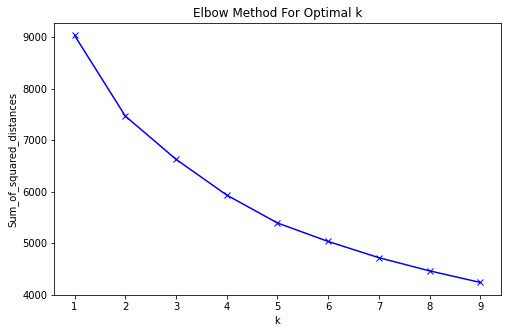

In [47]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [48]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 1.05844989e-01 -7.35807876e-02  1.73820107e-02  3.80517890e-03
   1.76096930e-03 -4.57544849e-03 -9.42013969e-04  1.24904156e-03
  -1.57699496e-04  8.00133081e-04]
 [-5.89317723e-03  1.31161253e-01  4.91865813e-03  2.30070621e-01
   1.10056993e-01 -2.29438868e-02  8.35910748e-05 -6.47591486e-03
   7.87953149e-03  3.06445068e-03]
 [-7.43222512e-02 -1.08611169e-02 -2.68564168e-02 -6.86359288e-03
  -6.85721157e-03  1.44739599e-03  5.20585361e-04 -2.55386386e-03
  -3.12099590e-04 -4.19532749e-04]
 [ 6.66131511e-02  1.04145064e-01 -1.38676836e-03 -3.09098672e-02
  -1.02565552e-02  7.47895148e-03 -5.82983395e-04  4.56040312e-03
  -7.40963860e-04 -1.70294133e-04]
 [-1.99353852e-01  1.61775618e-02  3.20575404e-01 -3.16174320e-02
   1.89878810e-02  7.94982321e-04  4.27533666e-03  1.09516866e-02
   1.04598285e-03 -3.90383280e-03]]


**Visualizing clustering among first two principal components**

In [49]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pc1,pc2,cluster
0,-0.113443,0.039084,2
1,-0.036988,0.108884,3
2,0.064282,0.103962,3
3,-0.093210,0.054093,2
4,0.094629,-0.037051,0


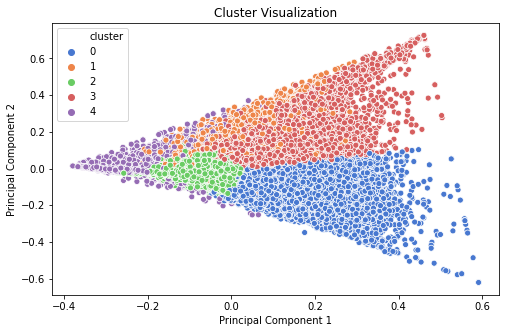

In [50]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster",palette="muted")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [0]:
cross_tabulated_df['cluster'] = c_preds

cluster1 = cross_tabulated_df[cross_tabulated_df.cluster == 0]
cluster2 = cross_tabulated_df[cross_tabulated_df.cluster == 1]
cluster3 = cross_tabulated_df[cross_tabulated_df.cluster == 2]
cluster4 = cross_tabulated_df[cross_tabulated_df.cluster == 3]
cluster5 = cross_tabulated_df[cross_tabulated_df.cluster == 4]


In [52]:
cluster1.shape

(55514, 135)

In [53]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.071658
fresh fruits                     21.678117
packaged vegetables fruits       11.992200
yogurt                            6.129445
packaged cheese                   5.000775
fresh herbs                       4.156123
milk                              3.986544
soy lactosefree                   3.700508
frozen produce                    3.295961
water seltzer sparkling water     3.074414
dtype: float64

In [54]:
cluster2.shape

(7953, 135)

In [55]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.358481
fresh fruits                     10.899032
packaged vegetables fruits        4.236515
fresh vegetables                  3.101094
water seltzer sparkling water     1.720734
milk                              1.615617
packaged cheese                   1.543317
frozen produce                    1.146863
chips pretzels                    1.141582
nuts seeds dried fruit            1.033698
dtype: float64

In [56]:
cluster3.shape

(98825, 135)

In [57]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.684108
fresh vegetables                 7.542262
yogurt                           7.179479
packaged vegetables fruits       5.964462
packaged cheese                  4.916398
chips pretzels                   4.476681
milk                             4.237430
water seltzer sparkling water    4.102818
refrigerated                     3.251272
ice cream ice                    3.096221
dtype: float64

In [58]:
cluster4.shape

(38594, 135)

In [60]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.694849
fresh vegetables                 15.160569
packaged vegetables fruits       12.178007
yogurt                            9.975229
milk                              5.988159
packaged cheese                   5.170052
soy lactosefree                   3.788128
water seltzer sparkling water     3.634658
bread                             3.220501
chips pretzels                    3.154325
dtype: float64

In [61]:
cluster5.shape

(5323, 135)

In [62]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.935187
fresh fruits                      3.274469
soft drinks                       2.796168
yogurt                            2.222619
energy granola bars               1.523577
chips pretzels                    1.316739
tea                               1.315611
milk                              1.312418
packaged vegetables fruits        1.211535
soy lactosefree                   1.066128
dtype: float64

Customer Clustering Results:

There are five Clusters identified :
According to current execution :  
- Cluster 1 results into 55514 customers having a very strong preference for fresh vegetables followed by fresh fruits.
- Cluster 2 results into 7953 customers having a very strong preference for packaged produce and fresh fruits.
- Cluster 3 results into 98825 customers who mostly order products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.
- Cluster 4 results into 38594 customers who buy fresh fruits and fresh vegetables.
- Cluster 5 results into 5323 customers who have strong preference for water seltzer sparkling water

# **Conclusion**

Thus we can see we have 5 clusters of customers in which each group (cluster) has a particular set of preferred products. Using the above data companies can strategize which product should be marketed to which customer.

Through the Association Rule mining companies can determine which products to recommend to the user while the person is shopping online.


## **Future Work**
- We can use Collaborative filtering to recommend products to a customer.
- Further a ML model can be built to predict product reorder probabilities in the customer's next order.
